In [553]:
import numpy as np
import pandas as pd

import pandas as pd

# Define file paths
paths = {
    "A100": "profile_NVIDIA_A100-SXM4-40GB.csv",
    "L4": "profile_NVIDIA_L4.csv",
    "T4": "profile_Tesla_T4.csv"
}

# Load, filter, rename, and store
dfs = {}
for gpu, path in paths.items():
    df = pd.read_csv(path)
    df["device"] = gpu  # rename GPU → device
    df = df[["B", "m", "memory_MB", "time_sec", "device"]]  # only desired columns
    df = df[(df["memory_MB"] > 0) & (df["time_sec"] > 0)]  # filter bad rows
    dfs[gpu] = df
    df.to_csv(f"cleaned_{gpu}.csv", index=False)  # optional save

# Access later:
df_a100 = dfs["A100"]
df_l4   = dfs["L4"]
df_t4   = dfs["T4"]

def compute_memory(B, m, d=128, bytes_per_float=4):
    """
    Estimate memory usage in MB given batch size B and block count m.
    Formula assumes 2B/m*d forward/backward activations and (B/m)^2 pairwise ops.
    """
    B_m = B / m
    mem_bytes = (2 * B_m * d + B_m**2) * bytes_per_float
    return mem_bytes / (1024 ** 2)

def compute_time(B, m, alpha=0.001, gamma=1.3, beta=0.5):
    """
    Estimate execution time (in seconds) for given B and m.
    - alpha scales block-parallelism cost (e.g., kernel overhead)
    - gamma scales forward complexity
    - beta is static system overhead
    """
    return alpha * m**2 + (B / m) ** gamma + beta

def generate_device_data(
    device_name="Device_A",
    n_samples=200,
    seed=42,
    d=128,
    alpha=0.001,
    gamma=1.3,
    beta=0.5,
    mem_noise_std=0.0,
    time_noise_std=0.0,
    min_mem_MB=1.0,
    min_time_sec=0.1
):
    """
    Generate synthetic time/memory data for a device.
    Supports noisy variants to simulate real hardware effects.
    """
    np.random.seed(seed)
    B_vals = np.random.randint(512, 8192, size=n_samples)
    m_vals = np.random.choice([1, 2, 4, 8, 16], size=n_samples)

    records = []
    for B, m in zip(B_vals, m_vals):
        mem = compute_memory(B, m, d=d)
        time = compute_time(B, m, alpha=alpha, gamma=gamma, beta=beta)

        mem += np.random.normal(0, mem_noise_std)
        time += np.random.normal(0, time_noise_std)

        mem = max(mem, min_mem_MB)
        time = max(time, min_time_sec)

        records.append((device_name, B, m, mem, time))

    return pd.DataFrame(records, columns=["device", "B", "m", "memory_MB", "time_sec"])

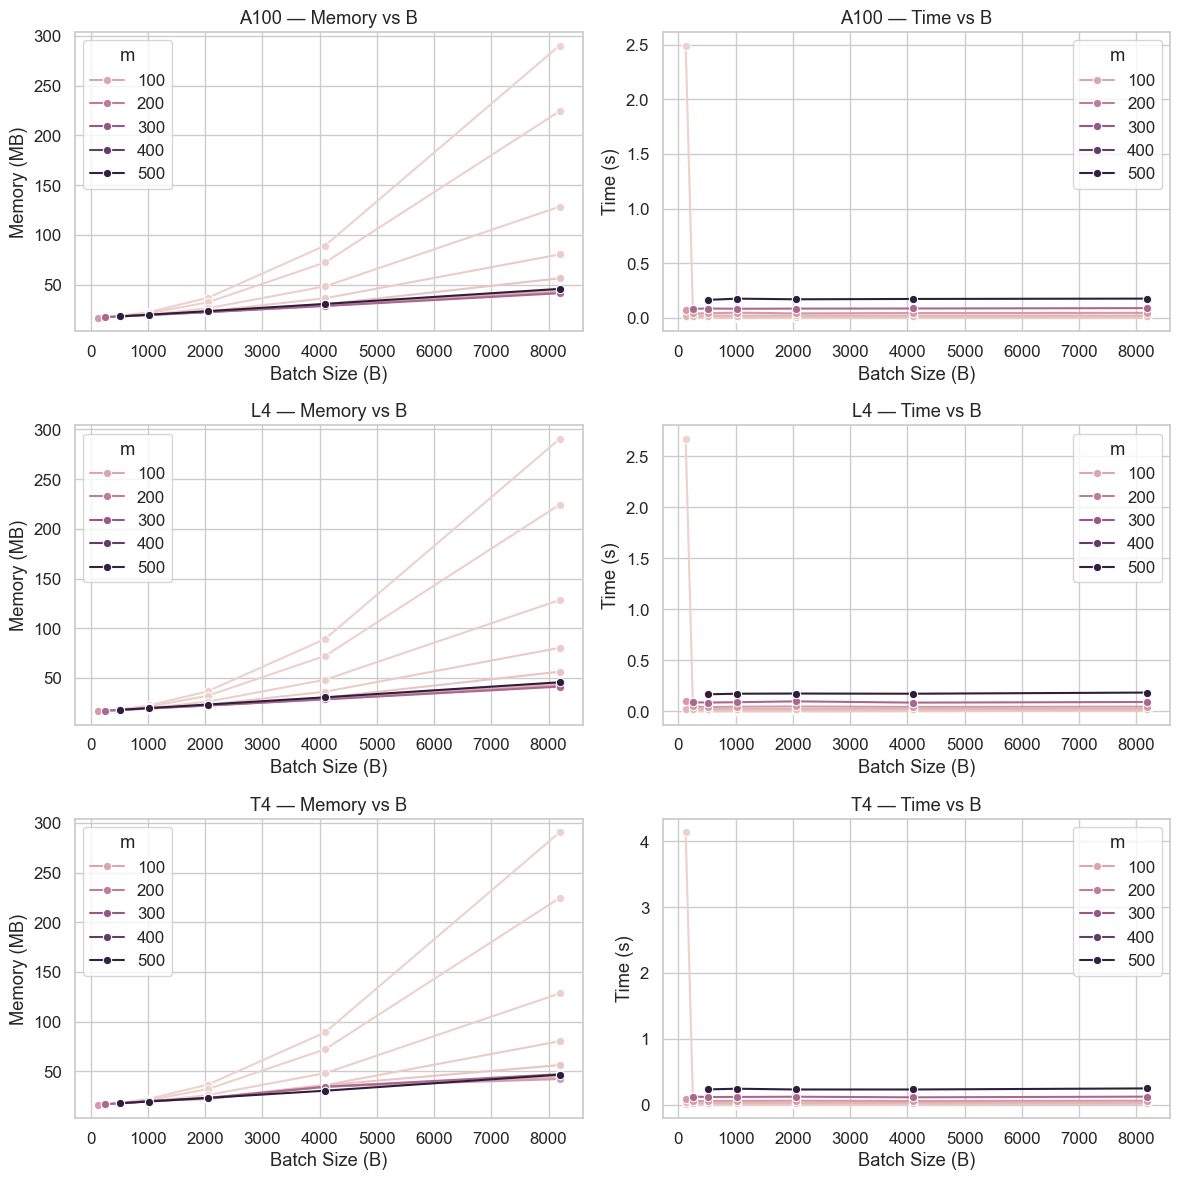

In [703]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === File paths ===
paths = {
    "A100": "profile_NVIDIA_A100-SXM4-40GB.csv",
    "L4": "profile_NVIDIA_L4.csv",
    "T4": "profile_Tesla_T4.csv"
}

# === Load and label
dfs = []
for label, path in paths.items():
    df = pd.read_csv(path)
    df["GPU"] = label
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
all_df = all_df[(all_df["memory_MB"] > 0) & (all_df["time_sec"] > 0)]

# === Set up subplots ===
gpus = all_df["GPU"].unique()
fig, axs = plt.subplots(len(gpus), 2, figsize=(12, 4 * len(gpus)))
if len(gpus) == 1: axs = [axs]  # handle edge case

# === Plot per GPU
for i, gpu in enumerate(gpus):
    df = all_df[all_df["GPU"] == gpu]
    sns.lineplot(data=df, x="B", y="memory_MB", hue="m", ax=axs[i][0], marker="o")
    axs[i][0].set_title(f"{gpu} — Memory vs B")
    axs[i][0].set_xlabel("Batch Size (B)")
    axs[i][0].set_ylabel("Memory (MB)")
    axs[i][0].grid(True)

    sns.lineplot(data=df, x="B", y="time_sec", hue="m", ax=axs[i][1], marker="o")
    axs[i][1].set_title(f"{gpu} — Time vs B")
    axs[i][1].set_xlabel("Batch Size (B)")
    axs[i][1].set_ylabel("Time (s)")
    axs[i][1].grid(True)

plt.tight_layout()
plt.show()

In [554]:
#df_A = generate_device_data(device_name="Device_A", seed=42)

#df_B = generate_device_data(
#     device_name="Device_B",
#     seed=99,
#     alpha=0.002,
#     gamma=1.15,
#     beta=0.3,
#     mem_noise_std=10,
#     time_noise_std=0.5
# )
df_A = generate_device_data(device_name="Device_A", seed=42)
df_B = pd.concat([df_a100, df_l4])
df_C = df_t4
import matplotlib.pyplot as plt
import seaborn as sns

def plot_device_profile(df, figsize=(14, 6)):
    """
    Visualize memory and time trends as a function of batch size B and block count m.
    Assumes DataFrame contains columns: ['device', 'B', 'm', 'memory_MB', 'time_sec']
    """
    sns.set(style="whitegrid", font_scale=1.1)
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Memory Plot
    sns.scatterplot(data=df, x="B", y="memory_MB", hue="m", style="device", ax=axes[0], palette="viridis", s=60)
    axes[0].set_title("Memory Usage vs Batch Size")
    axes[0].set_xlabel("Batch Size (B)")
    axes[0].set_ylabel("Memory (MB)")

    # Time Plot
    sns.scatterplot(data=df, x="B", y="time_sec", hue="m", style="device", ax=axes[1], palette="magma", s=60)
    axes[1].set_title("Execution Time vs Batch Size")
    axes[1].set_xlabel("Batch Size (B)")
    axes[1].set_ylabel("Time (sec)")

    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5)
    plt.tight_layout()
    plt.show()

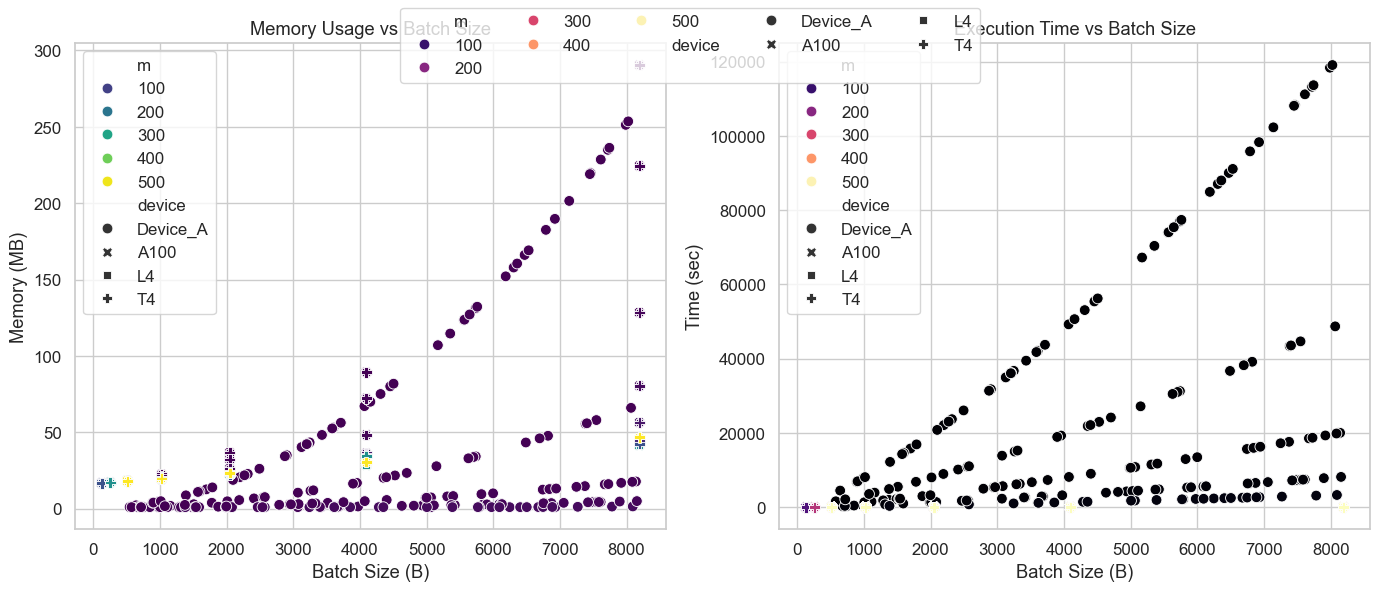

In [555]:

df_all = pd.concat([df_A, df_B, df_C])
plot_device_profile(df_all)

In [567]:
def prepare_features(df, eps=1e-3):
    """
    Add engineered features for memory and time modeling.
    Includes log, inverse, interaction, and memory transformations.
    """
    df = df.copy()

    # Core engineered features
    df["logB"] = np.log(df["B"])
    df["logm"] = np.log(df["m"])
    df["1_over_B"] = 1 / df["B"]
    df["1_over_m"] = 1 / df["m"]
    df["B_over_m"] = df["B"] / df["m"]
    df["log_B_over_m"] = np.log(df["B_over_m"])

    # Time transformation
    df["log_time"] = np.log(df["time_sec"])

    # Memory transformations
    df["log_memory"] = np.log(df["memory_MB"] + eps)
    df["memory_residual"] = df["memory_MB"] - (df["B"] / df["m"])

    # Nonlinear/interaction terms
    df["m_sq"] = df["m"] ** 2
    df["B_times_m"] = df["B"] * df["m"]
    df["log_Bm_interact"] = df["logB"] * df["logm"]
    df["memory_z"] = (df["memory_MB"] - df["memory_MB"].mean()) / df["memory_MB"].std()
    # Optional: tidy up column order
    ordered_cols = [
        "B", "m", "logB", "logm", "1_over_B", "1_over_m", "B_over_m", "log_B_over_m",
        "m_sq", "B_times_m", "log_Bm_interact", 
        "memory_MB", "log_memory", "memory_residual","memory_z",
        "time_sec", "log_time"
    ]
    df = df[[col for col in ordered_cols if col in df.columns] + 
            [col for col in df.columns if col not in ordered_cols]]

    return df

In [557]:
features = [
        "B", "m", "logB", "logm", "1_over_B", "1_over_m", "B_over_m", "log_B_over_m",
        "m_sq", "B_times_m", "log_Bm_interact"
    ]

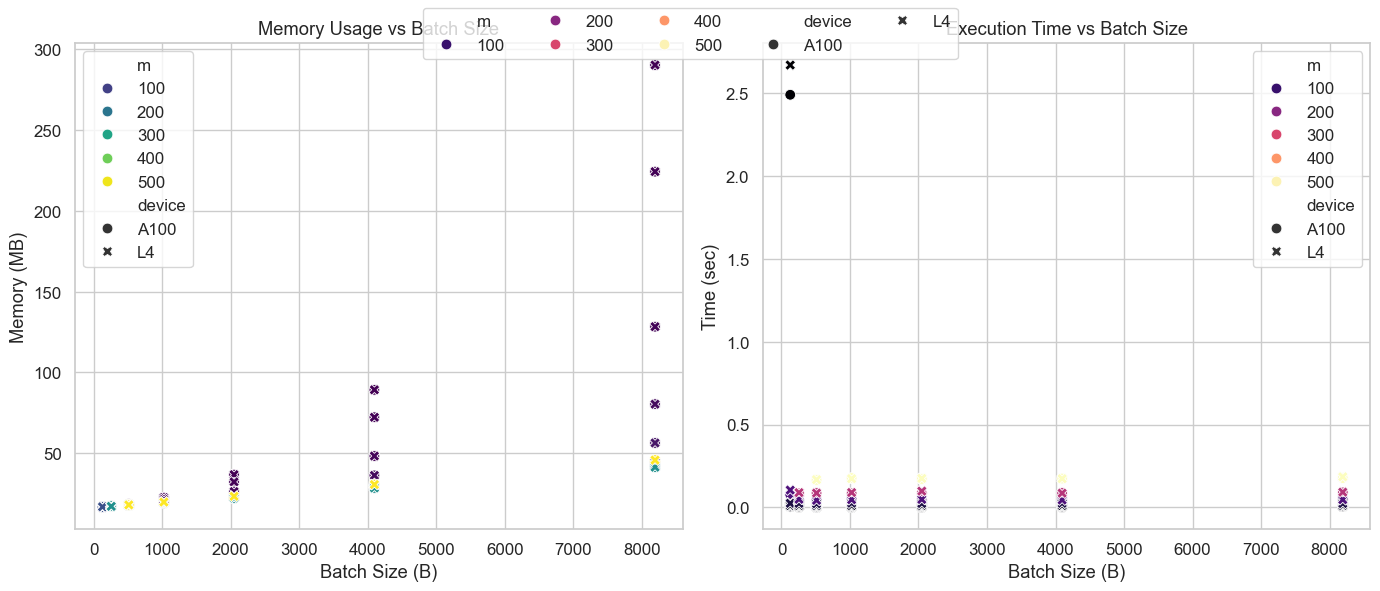

In [568]:
df_B = prepare_features(df_B)
plot_device_profile(df_B)



In [576]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import torch

class NormalizedSplitDataset:
    def __init__(
        self,
        df,
        input_cols=["logB", "logm", "B_over_m", "m_sq"],
        target_cols=["memory_MB", "log_time"],
        test_size=0.1,
        random_state=42,
        representative_sampling=False,
        n_clusters=100,
        cluster_on='X'
    ):
        """
        Prepares train/val tensors from a DataFrame with normalization and optional representative sampling.
        """
        self.df = df.copy()
        self.test_size = test_size
        self.random_state = random_state

        X_raw = self.df[input_cols].values
        y_raw = self.df[target_cols].copy().values

        # Safety: clip time for log transform
        if "log_time" in target_cols:
            log_index = target_cols.index("log_time")
            y_raw[:, log_index] = np.log(np.clip(self.df["time_sec"].values, 1e-6, None))

        # Representative KMeans sampling
        if representative_sampling:
            features_for_clustering = {
                'X': X_raw,
                'y': y_raw
            }.get(cluster_on)

            if features_for_clustering is None:
                raise ValueError("cluster_on must be 'X' or 'y'")

            features_scaled = StandardScaler().fit_transform(features_for_clustering)
            kmeans = KMeans(n_clusters=min(n_clusters, len(features_scaled)), random_state=random_state)
            kmeans.fit(features_scaled)

            selected_indices = [
                np.argmin(np.linalg.norm(features_scaled - center, axis=1))
                for center in kmeans.cluster_centers_
            ]
            selected_mask = np.zeros(len(df), dtype=bool)
            selected_mask[selected_indices] = True

            X_train, y_train = X_raw[selected_mask], y_raw[selected_mask]
            X_val, y_val     = X_raw[~selected_mask], y_raw[~selected_mask]
        else:
            X_train, X_val, y_train, y_val = train_test_split(
                X_raw, y_raw, test_size=test_size, random_state=random_state
            )

        # Normalize
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

        self.X_train = torch.from_numpy(self.X_scaler.fit_transform(X_train)).float()
        self.X_val   = torch.from_numpy(self.X_scaler.transform(X_val)).float()
        self.y_train = torch.from_numpy(self.y_scaler.fit_transform(y_train)).float()
        self.y_val   = torch.from_numpy(self.y_scaler.transform(y_val)).float()

    def get_tensors(self):
        return self.X_train, self.y_train, self.X_val, self.y_val

    def scale_input(self, X_np):
        return self.X_scaler.transform(X_np)

    def descale_output(self, y_scaled_np):
        return self.y_scaler.inverse_transform(y_scaled_np)

In [577]:

df_A= prepare_features(df_A)
ds_A = NormalizedSplitDataset(df_A, features)

X_train, y_train, X_val, y_val = ds_A.get_tensors()

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")


Train shape: torch.Size([180, 11]), Val shape: torch.Size([20, 11])


In [561]:
import torch.nn as nn
class ResourceEstimatorMLP(nn.Module):
    def __init__(self, input_dim=4, output_dim=2, hidden_layers=(256, 128, 64), 
                 activation='leaky_relu', dropout=0.1, use_batchnorm=False):
        super().__init__()

        layers = []
        in_dim = input_dim
        act_fn_map = {
            "tanh": nn.Tanh(),
            "leaky_relu": nn.LeakyReLU(),
            "relu": nn.ReLU(),
            "gelu": nn.GELU(),
        }
        act_fn = act_fn_map.get(activation.lower(), nn.LeakyReLU())

        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(act_fn)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h

        layers.append(nn.Linear(in_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def __repr__(self):
        return f"ResourceEstimatorMLP(layers={self.model})"


In [570]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = ResourceEstimatorMLP(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_layers=(256, 128, 64),
    activation='tanh',
    dropout=0.1
).to("cuda" if torch.cuda.is_available() else "cpu")

print(model)

ResourceEstimatorMLP(layers=Sequential(
  (0): Linear(in_features=11, out_features=256, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): Tanh()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=64, out_features=2, bias=True)
))


In [571]:
def train_model(
    model, train_loader, val_loader,
    epochs=100, lr=5e-4, weight_decay=5e-4,
    scheduler=None, patience=None
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")
    best_model = None
    train_losses, val_losses = [], []
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if scheduler:
            scheduler.step(val_loss)

        if patience and epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(best_model)
    return model, train_losses, val_losses

In [572]:
from torch.utils.data import DataLoader

def make_dataloaders(X_train, y_train, X_val, y_val, batch_size=64):
    train_ds = torch.utils.data.TensorDataset(X_train, y_train)
    val_ds   = torch.utils.data.TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [573]:
train_loader , val_loader = make_dataloaders(X_train, y_train, X_val, y_val)
trained_model, train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    epochs=200,
    patience=10
)

Epoch   1 | Train Loss: 0.7448 | Val Loss: 1.3152
Epoch   2 | Train Loss: 0.5551 | Val Loss: 0.9917
Epoch   3 | Train Loss: 0.3650 | Val Loss: 0.7501
Epoch   4 | Train Loss: 0.2529 | Val Loss: 0.5852
Epoch   5 | Train Loss: 0.2001 | Val Loss: 0.4905
Epoch   6 | Train Loss: 0.1810 | Val Loss: 0.4448
Epoch   7 | Train Loss: 0.1987 | Val Loss: 0.4255
Epoch   8 | Train Loss: 0.1666 | Val Loss: 0.4134
Epoch   9 | Train Loss: 0.1436 | Val Loss: 0.3975
Epoch  10 | Train Loss: 0.1545 | Val Loss: 0.3772
Epoch  11 | Train Loss: 0.1447 | Val Loss: 0.3592
Epoch  12 | Train Loss: 0.1503 | Val Loss: 0.3477
Epoch  13 | Train Loss: 0.1274 | Val Loss: 0.3400
Epoch  14 | Train Loss: 0.1276 | Val Loss: 0.3332
Epoch  15 | Train Loss: 0.1284 | Val Loss: 0.3240
Epoch  16 | Train Loss: 0.1298 | Val Loss: 0.3090
Epoch  17 | Train Loss: 0.0765 | Val Loss: 0.2935
Epoch  18 | Train Loss: 0.0904 | Val Loss: 0.2768
Epoch  19 | Train Loss: 0.0802 | Val Loss: 0.2600
Epoch  20 | Train Loss: 0.0727 | Val Loss: 0.2449


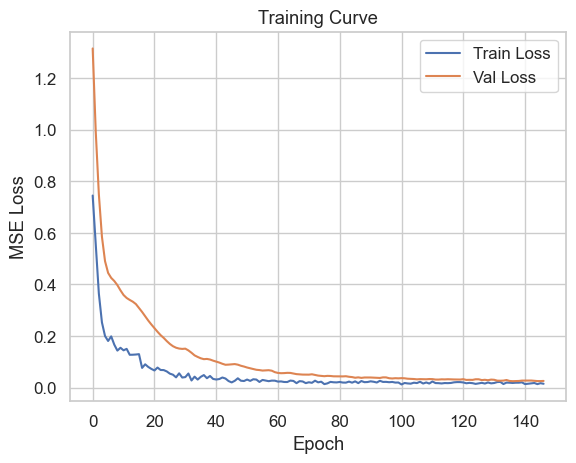

In [574]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve")
plt.legend()
plt.grid(True)
plt.show()

In [82]:
import matplotlib.pyplot as plt

def plot_prediction_scatter(mem_true, mem_pred, time_true, time_pred, title_suffix=""):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Memory plot
    axes[0].scatter(mem_true, mem_pred, c='tab:blue', alpha=0.6, edgecolor='k')
    axes[0].plot([min(mem_true), max(mem_true)], [min(mem_true), max(mem_true)], 'k--')
    axes[0].set_xlabel("True Memory (MB)")
    axes[0].set_ylabel("Predicted Memory (MB)")
    axes[0].set_title(f"Memory Prediction Scatter {title_suffix}")

    # Time plot
    axes[1].scatter(time_true, time_pred, c='tab:red', alpha=0.6, edgecolor='k')
    axes[1].plot([min(time_true), max(time_true)], [min(time_true), max(time_true)], 'k--')
    axes[1].set_xlabel("True Time (sec)")
    axes[1].set_ylabel("Predicted Time (sec)")
    axes[1].set_title(f"Time Prediction Scatter {title_suffix}")

    plt.tight_layout()
    plt.show()

In [579]:
def evaluate_model(model_or_tuple, X_val, y_val, dataset_wrapper, verbose=True, num_samples=5):
    """
    Evaluate model (with optional bias correction) on validation set.
    Supports input as either model or [model, theta].
    Returns RMSE and relative error for memory and time.
    """
    # Handle model + theta input
    if isinstance(model_or_tuple, (list, tuple)) and len(model_or_tuple) == 2:
        model, theta = model_or_tuple
    else:
        model = model_or_tuple
        theta = None

    model.eval()
    device = next(model.parameters()).device
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    with torch.no_grad():
        base_pred = model(X_val)

        if theta is not None:
            ones = torch.ones(X_val.size(0), 1, device=device)
            X_design = torch.cat([X_val, ones], dim=1)
            correction = X_design @ theta.to(device)
            y_pred = base_pred + correction
        else:
            y_pred = base_pred

    y_val_np = y_val.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    # De-normalize using dataset's scalers
    y_val_real = dataset_wrapper.descale_output(y_val_np)
    y_pred_real = dataset_wrapper.descale_output(y_pred_np)

    mem_true, time_true = y_val_real[:, 0], np.exp(y_val_real[:, 1])
    mem_pred, time_pred = y_pred_real[:, 0], np.exp(y_pred_real[:, 1])

    # RMSE
    mem_rmse = np.sqrt(np.mean((mem_true - mem_pred)**2))
    time_rmse = np.sqrt(np.mean((time_true - time_pred)**2))

    # Relative Errors
    mem_rel_err = np.mean(np.abs(mem_true - mem_pred) / mem_true)
    time_rel_err = np.mean(np.abs(time_true - time_pred) / time_true)

    if verbose:
        print(f"📦 Mem RMSE: {mem_rmse:.2f} MB")
        print(f"⏱ Time RMSE: {time_rmse:.2f} sec")
        print(f"📦 Mem Relative Error: {mem_rel_err * 100:.2f}%")
        print(f"⏱ Time Relative Error: {time_rel_err * 100:.2f}%")
        for i in range(min(num_samples, len(mem_true))):
            print(f"[{i}] GT → mem={mem_true[i]:.2f}, time={time_true[i]:.2f}  |  Pred → mem={mem_pred[i]:.2f}, time={time_pred[i]:.2f}")

    plot_prediction_scatter(mem_true, mem_pred, time_true, time_pred)

    return mem_rmse, time_rmse, mem_rel_err, time_rel_err

📦 Mem RMSE: 10.79 MB
⏱ Time RMSE: 2280.18 sec
📦 Mem Relative Error: 136.01%
⏱ Time Relative Error: 9.56%
[0] GT → mem=8.02, time=11480.59  |  Pred → mem=2.52, time=11478.16
[1] GT → mem=16.86, time=19279.94  |  Pred → mem=14.57, time=19964.57
[2] GT → mem=12.63, time=15785.83  |  Pred → mem=15.60, time=17609.26
[3] GT → mem=69.98, time=50631.19  |  Pred → mem=74.69, time=54184.20
[4] GT → mem=3.01, time=5655.59  |  Pred → mem=0.22, time=5703.50


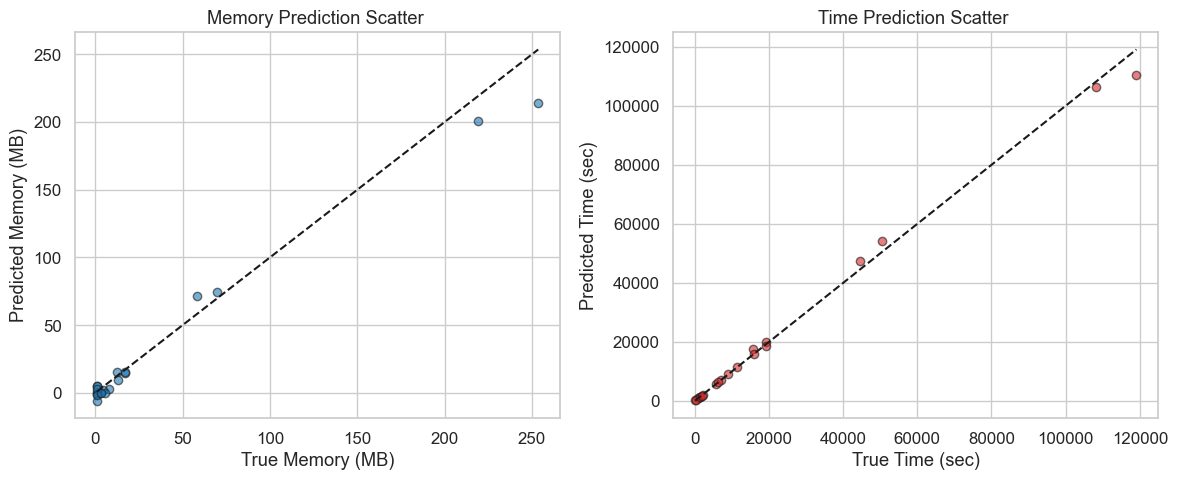

(np.float32(10.792486),
 np.float32(2280.177),
 np.float32(1.3601096),
 np.float32(0.09555105))

In [580]:
evaluate_model(trained_model, X_val, y_val, ds_A)

In [581]:
import torch
import torch.nn as nn
import numpy as np
import copy

def few_shot_finetune_torch(
    model,
    X_few, y_few,
    X_rest, y_rest,
    epochs: int = 20,
    lr: float = 1e-4,
    weight_decay: float = 5e-4,
    scaler=None,
    verbose=True,
    patience: int = 5,
    min_delta: float = 1e-4
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_few, y_few = X_few.to(device), y_few.to(device)
    X_rest, y_rest = X_rest.to(device), y_rest.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best_loss = float("inf")
    best_model = copy.deepcopy(model.state_dict())
    patience_counter = 0

    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        preds = model(X_few)
        loss = loss_fn(preds, y_few)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            val_preds = model(X_rest)
            val_loss = loss_fn(val_preds, y_rest).item()
            model.train()

        if verbose:
            print(f"Epoch {epoch}/{epochs} — Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

        if val_loss + min_delta < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose:
                    print(f"🛑 Early stopping at epoch {epoch}")
                break

    model.load_state_dict(best_model)
    model.eval()

    with torch.no_grad():
        pred_rest = model(X_rest).cpu().numpy()
        y_rest_np = y_rest.cpu().numpy()

    if scaler:
        pred_real = scaler.descale_output(pred_rest)
        y_real    = scaler.descale_output(y_rest_np)

        mem_pred = pred_real[:, 0]
        mem_true = y_real[:, 0]
        time_pred = np.exp(pred_real[:, 1])
        time_true = np.exp(y_real[:, 1])
    else:
        mem_pred = pred_rest[:, 0]
        mem_true = y_rest_np[:, 0]
        time_pred = np.exp(pred_rest[:, 1])
        time_true = np.exp(y_rest_np[:, 1])

    mem_rmse = np.sqrt(np.mean((mem_pred - mem_true) ** 2))
    time_rmse = np.sqrt(np.mean((time_pred - time_true) ** 2))

    if verbose:
        print(f"\n📦 Mem RMSE (real): {mem_rmse:.2f} MB")
        print(f"⏱ Time RMSE (real): {time_rmse:.2f} sec")

    return model

Epoch 1/200 — Train Loss: 1.4186, Val Loss: 1.6946
Epoch 2/200 — Train Loss: 1.4010, Val Loss: 1.6565
Epoch 3/200 — Train Loss: 1.3081, Val Loss: 1.6196
Epoch 4/200 — Train Loss: 1.2893, Val Loss: 1.5837
Epoch 5/200 — Train Loss: 1.2376, Val Loss: 1.5488
Epoch 6/200 — Train Loss: 1.2005, Val Loss: 1.5148
Epoch 7/200 — Train Loss: 1.1454, Val Loss: 1.4818
Epoch 8/200 — Train Loss: 1.1045, Val Loss: 1.4499
Epoch 9/200 — Train Loss: 1.1154, Val Loss: 1.4189
Epoch 10/200 — Train Loss: 1.0748, Val Loss: 1.3887
Epoch 11/200 — Train Loss: 1.0140, Val Loss: 1.3592
Epoch 12/200 — Train Loss: 0.9997, Val Loss: 1.3306
Epoch 13/200 — Train Loss: 0.9714, Val Loss: 1.3028
Epoch 14/200 — Train Loss: 0.9390, Val Loss: 1.2759
Epoch 15/200 — Train Loss: 0.9139, Val Loss: 1.2498
Epoch 16/200 — Train Loss: 0.8708, Val Loss: 1.2244
Epoch 17/200 — Train Loss: 0.8438, Val Loss: 1.1999
Epoch 18/200 — Train Loss: 0.8272, Val Loss: 1.1760
Epoch 19/200 — Train Loss: 0.7928, Val Loss: 1.1530
Epoch 20/200 — Train 

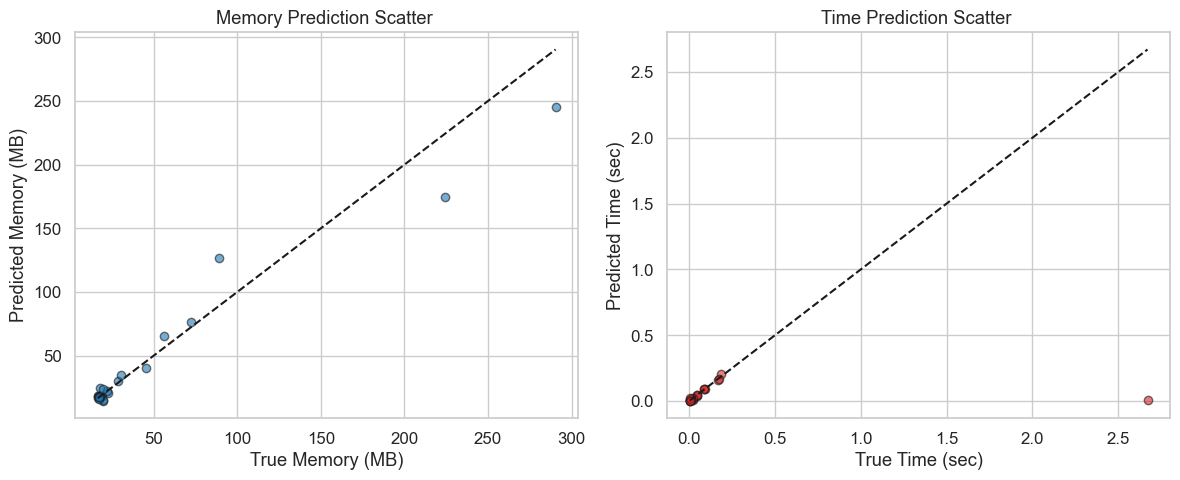

(np.float32(16.080544),
 np.float32(0.54296196),
 np.float32(0.12047761),
 np.float32(0.33829293))

In [582]:
ds_B = NormalizedSplitDataset(df_B, features,test_size=0.8)
X_rest, y_rest, X_few, y_few = ds_B.get_tensors()

ft_model = few_shot_finetune_torch(
    trained_model,           # use the model trained on Device_A
    X_few, y_few,
    X_rest, y_rest,
    epochs=200,
    lr=1e-4,
    scaler=ds_B              # pass scaler for unscaled error
)

# Re-evaluate
evaluate_model(ft_model, X_rest, y_rest, ds_B)

📦 Mem RMSE: 10.32 MB
⏱ Time RMSE: 0.60 sec
📦 Mem Relative Error: 16.24%
⏱ Time Relative Error: 54.76%
[0] GT → mem=16.63, time=4.14  |  Pred → mem=17.22, time=0.02
[1] GT → mem=16.72, time=0.04  |  Pred → mem=11.21, time=0.04
[2] GT → mem=23.26, time=0.01  |  Pred → mem=21.02, time=0.01
[3] GT → mem=36.28, time=0.01  |  Pred → mem=39.42, time=0.01
[4] GT → mem=17.00, time=0.06  |  Pred → mem=11.66, time=0.05


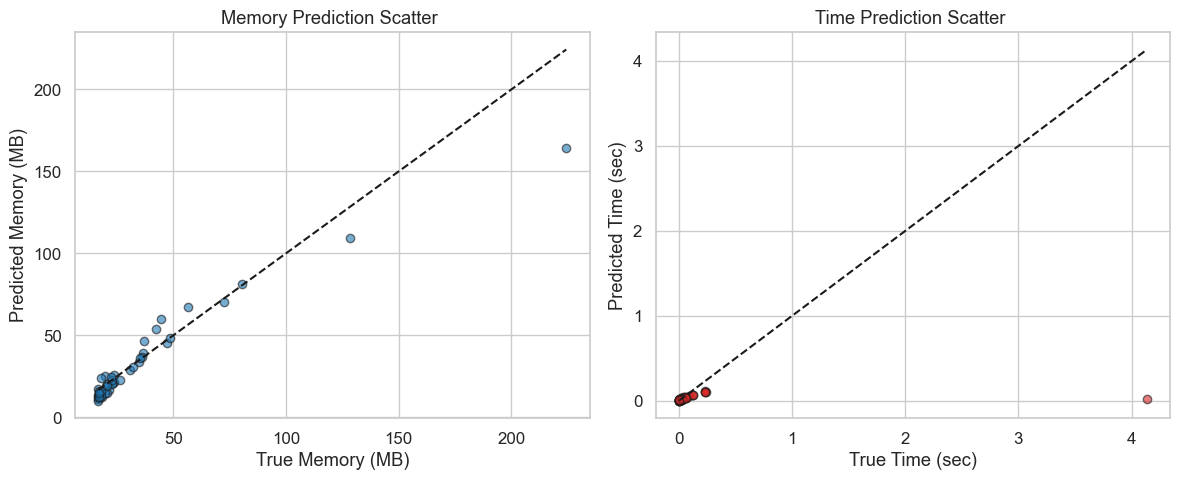

(np.float32(10.320645),
 np.float32(0.5953792),
 np.float32(0.1624106),
 np.float32(0.54764146))

In [583]:
import numpy as np
import pandas as pd


#df_C = generate_device_C("DeviceC", n_samples=300, seed=68, d=128)
df_C = prepare_features(df_C) 

ds_C = NormalizedSplitDataset(df_C,features, test_size=0.8)
X_train, y_train, X_val, y_val = ds_C.get_tensors()
evaluate_model(ft_model, X_val, y_val, ds_C)

In [584]:
# Generate and feature-engineer DeviceC
#df_C = generate_device_C("DeviceC", n_samples=300, seed=68)
df_C = prepare_features(df_C)

# Use 5% of DeviceC data for fine-tuning (few-shot), rest for evaluation
ds_C = NormalizedSplitDataset(df_C,features, test_size=0.8)
X_rest, y_rest, X_few, y_few = ds_C.get_tensors()
ft_model_C = few_shot_finetune_torch(
    ft_model,  # model originally trained on Device A
    X_few, y_few,
    X_rest, y_rest,
    epochs=100,
    lr=1e-4,
    scaler=ds_C
)

Epoch 1/100 — Train Loss: 0.3027, Val Loss: 0.0791
Epoch 2/100 — Train Loss: 0.2962, Val Loss: 0.0748
Epoch 3/100 — Train Loss: 0.2859, Val Loss: 0.0708
Epoch 4/100 — Train Loss: 0.2890, Val Loss: 0.0672
Epoch 5/100 — Train Loss: 0.2917, Val Loss: 0.0638
Epoch 6/100 — Train Loss: 0.2618, Val Loss: 0.0607
Epoch 7/100 — Train Loss: 0.2870, Val Loss: 0.0577
Epoch 8/100 — Train Loss: 0.2786, Val Loss: 0.0550
Epoch 9/100 — Train Loss: 0.2613, Val Loss: 0.0528
Epoch 10/100 — Train Loss: 0.2397, Val Loss: 0.0506
Epoch 11/100 — Train Loss: 0.2603, Val Loss: 0.0490
Epoch 12/100 — Train Loss: 0.2679, Val Loss: 0.0480
Epoch 13/100 — Train Loss: 0.2500, Val Loss: 0.0471
Epoch 14/100 — Train Loss: 0.2779, Val Loss: 0.0465
Epoch 15/100 — Train Loss: 0.2613, Val Loss: 0.0460
Epoch 16/100 — Train Loss: 0.2678, Val Loss: 0.0456
Epoch 17/100 — Train Loss: 0.2560, Val Loss: 0.0455
Epoch 18/100 — Train Loss: 0.2529, Val Loss: 0.0457
Epoch 19/100 — Train Loss: 0.2637, Val Loss: 0.0459
Epoch 20/100 — Train 

In [585]:
import torch
import torch.nn as nn
import numpy as np
import copy

def few_shot_finetune_torch_with_bias(
    model,
    X_few, y_few,
    X_rest, y_rest,
    epochs: int = 20,
    lr: float = 1e-4,
    weight_decay: float = 5e-4,
    scaler=None,
    verbose=True,
    patience: int = 5,
    min_delta: float = 1e-4
):
    """
    Few-shot fine-tuning with a residual correction layer and early stopping.
    Trains model on few-shot data, then fits bias correction on residuals.
    Returns fine-tuned model, correction weights, and corrected predictions.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    X_few, y_few = X_few.to(device), y_few.to(device)
    X_rest, y_rest = X_rest.to(device), y_rest.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best_loss = float("inf")
    best_model = copy.deepcopy(model.state_dict())
    patience_counter = 0

    # === Fine-tune on few-shot ===
    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        preds = model(X_few)
        loss = loss_fn(preds, y_few)
        loss.backward()
        optimizer.step()

        # Early stopping on val set (X_rest)
        with torch.no_grad():
            model.eval()
            val_preds = model(X_rest)
            val_loss = loss_fn(val_preds, y_rest).item()
            model.train()

        if verbose:
            print(f"Epoch {epoch}/{epochs} — Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

        if val_loss + min_delta < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose:
                    print(f"🛑 Early stopping at epoch {epoch}")
                break

    model.load_state_dict(best_model)
    model.eval()

    # === Fit linear bias corrector ===
    with torch.no_grad():
        preds_few = model(X_few)
    residuals = y_few - preds_few
    ones = torch.ones(X_few.size(0), 1, device=device)
    X_design = torch.cat([X_few, ones], dim=1)
    theta = torch.pinverse(X_design) @ residuals  # [F+1, 2]

    # === Apply to holdout set ===
    with torch.no_grad():
        base_pred = model(X_rest)
    ones_rest = torch.ones(X_rest.size(0), 1, device=device)
    X_design_rest = torch.cat([X_rest, ones_rest], dim=1)
    correction = X_design_rest @ theta
    pred_corr = base_pred + correction

    # === Evaluation ===
    y_rest_np = y_rest.cpu().numpy()
    pred_corr_np = pred_corr.cpu().numpy()

    if scaler:
        y_real = scaler.descale_output(y_rest_np)
        y_pred_real = scaler.descale_output(pred_corr_np)

        # Apply exp to both memory and time predictions/ground-truth
        mem_pred = y_pred_real[:, 0]
        mem_true = y_real[:, 0]
        time_pred = np.exp(y_pred_real[:, 1])
        time_true = np.exp(y_real[:, 1])

        mem_rmse = np.sqrt(((mem_pred - mem_true) ** 2).mean())
        time_rmse = np.sqrt(((time_pred - time_true) ** 2).mean())
        rel_mem = np.mean(np.abs(mem_pred - mem_true) / mem_true)
        rel_time = np.mean(np.abs(time_pred - time_true) / time_true)

        if verbose:
            print(f"\n📦 Mem RMSE (real):  {mem_rmse:.2f} MB")
            print(f"⏱ Time RMSE (real): {time_rmse:.2f} sec")
            print(f"📦 Mem RE: {rel_mem*100:.2f}% | ⏱ Time RE: {rel_time*100:.2f}%")

    else:
        mem_rmse = np.sqrt(((pred_corr_np[:, 0] - y_rest_np[:, 0]) ** 2).mean())
        time_rmse = np.sqrt(((pred_corr_np[:, 1] - y_rest_np[:, 1]) ** 2).mean())

        if verbose:
            print(f"\n📦 Mem RMSE (scaled):  {mem_rmse:.4f}")
            print(f"⏱ Time RMSE (scaled): {time_rmse:.4f}")

    return model, theta, pred_corr_np

In [586]:
ft_model_bias, theta_bias, corrected_preds = few_shot_finetune_torch_with_bias(
    ft_model,
    X_few, y_few,
    X_rest, y_rest,
    epochs=100,
    lr=1e-4,
    scaler=ds_C,
    verbose=True
)

Epoch 1/100 — Train Loss: 0.2605, Val Loss: 0.0453
Epoch 2/100 — Train Loss: 0.2474, Val Loss: 0.0464
Epoch 3/100 — Train Loss: 0.2666, Val Loss: 0.0478
Epoch 4/100 — Train Loss: 0.2618, Val Loss: 0.0483
Epoch 5/100 — Train Loss: 0.2552, Val Loss: 0.0483
Epoch 6/100 — Train Loss: 0.2500, Val Loss: 0.0487
🛑 Early stopping at epoch 6

📦 Mem RMSE (real):  26.78 MB
⏱ Time RMSE (real): 0.36 sec
📦 Mem RE: 20.98% | ⏱ Time RE: 162.83%


In [587]:
def plot_bias_corrected_predictions(y_true_scaled, y_pred_scaled, scaler, title_suffix=""):
    """
    Scatter plot comparing bias-corrected predictions vs true values.
    Assumes inputs are still in scaled space and need inverse-transform.
    """
    # Inverse-transform
    y_true_real = scaler.descale_output(y_true_scaled)
    y_pred_real = scaler.descale_output(y_pred_scaled)

    mem_true, time_true = y_true_real[:, 0], np.exp(y_true_real[:, 1])
    mem_pred, time_pred = y_pred_real[:, 0], np.exp(y_pred_real[:, 1])

    plot_prediction_scatter(
        mem_true, mem_pred,
        time_true, time_pred,
        title_suffix=f"(Bias Corrected {title_suffix})"
    )

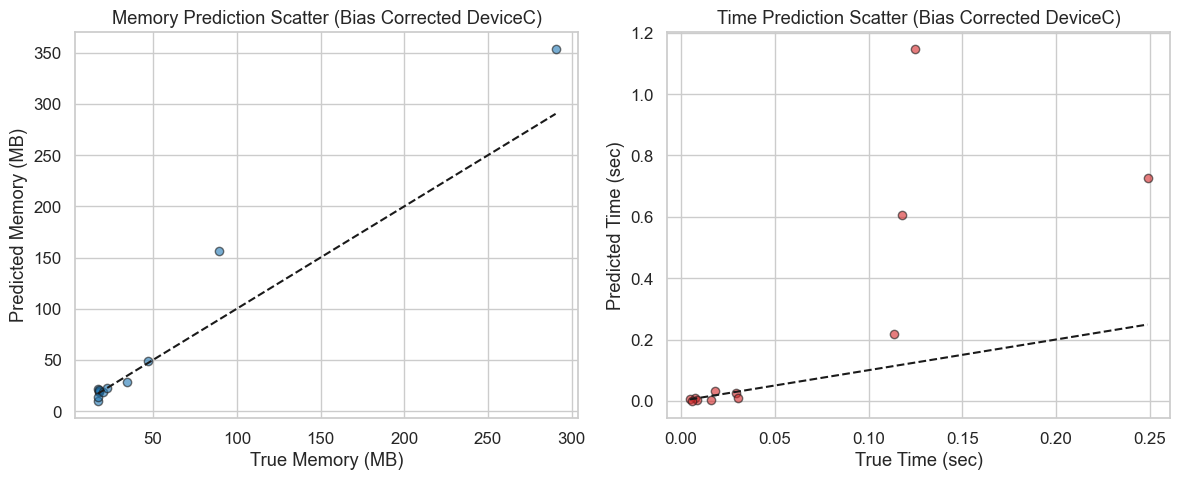

In [588]:
plot_bias_corrected_predictions(y_rest.cpu().numpy(), corrected_preds, scaler=ds_C, title_suffix="DeviceC")

In [589]:
features

['B',
 'm',
 'logB',
 'logm',
 '1_over_B',
 '1_over_m',
 'B_over_m',
 'log_B_over_m',
 'm_sq',
 'B_times_m',
 'log_Bm_interact']

In [625]:
def build_feature_vector(B, m):
    """
    Constructs a feature vector in the same order as the training set.
    """
    return np.array([[
        B,                      # raw B
        m,                      # raw m
        np.log(B),              # logB
        np.log(m),              # logm
        1 / B,                  # 1_over_B
        1 / m,                  # 1_over_m
        B / m,                  # B_over_m
        np.log(B / m),          # log_B_over_m
        m ** 2,                 # m_sq
        B * m,                  # B_times_m
        np.log(B) * np.log(m)   # log_Bm_interact
    ]])
def generate_df_plot_from_df(
    df_input,
    model_or_tuple,
    X_scaler,
    y_scaler,
    apply_exp_time=True
):
    """
    Evaluate and compare true vs predicted memory and time (with optional bias correction).
    
    Args:
        df_input (pd.DataFrame): Must contain columns: B, m, memory_MB, log_time
        model_or_tuple: model or [model, theta]
        X_scaler, y_scaler: fitted scalers
        apply_exp_time (bool): Whether to apply exp() to time

    Returns:
        pd.DataFrame: with true/predicted mem/time and error terms
    """
    # Handle bias correction input
    if isinstance(model_or_tuple, (list, tuple)) and len(model_or_tuple) == 2:
        model, theta = model_or_tuple
    else:
        model = model_or_tuple
        theta = None

    device = next(model.parameters()).device
    model.eval()
    rows = []

    for _, row in df_input.iterrows():
        B, m = row["B"], row["m"]

        # Use log_memory and log_time for consistent comparison
        mem_true = row["memory_MB"]
        time_true = np.exp(row["log_time"]) if apply_exp_time else row["log_time"]

        x_raw = build_feature_vector(B, m)
        x_scaled = X_scaler.transform(x_raw)
        x_tensor = torch.from_numpy(x_scaled).float().to(device)

        with torch.no_grad():
            base_pred = model(x_tensor)

            if theta is not None:
                x_design = torch.cat([x_tensor, torch.ones(1, 1, device=device)], dim=1)
                correction = x_design @ theta.to(device)
                y_pred_scaled = base_pred + correction
            else:
                y_pred_scaled = base_pred

            y_pred = y_scaler.inverse_transform(y_pred_scaled.cpu().numpy())[0]

        mem_pred = y_pred[0]
        time_pred = np.exp(y_pred[1]) if apply_exp_time else y_pred[1]

        rows.append({
            "B": B,
            "m": m,
            "mem_true": mem_true,
            "mem_pred": mem_pred,
            "time_true": time_true,
            "time_pred": time_pred,
            "mem_err": abs(mem_pred - mem_true),
            "time_err": abs(time_pred - time_true),
        })

    return pd.DataFrame(rows)

In [591]:
import matplotlib.pyplot as plt

def plot_by_m_and_B_fixed(df_plot, m0, B0):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # === Vary B, fixed m ===
    sub_m = df_plot[df_plot['m'] == m0].sort_values('B')
    axes[0, 0].plot(sub_m['B'], sub_m['mem_true'], marker='o', label='True Mem')
    axes[0, 0].plot(sub_m['B'], sub_m['mem_pred'], marker='x', linestyle='--', label='Pred Mem')
    axes[0, 1].plot(sub_m['B'], sub_m['time_true'], marker='o', label='True Time')
    axes[0, 1].plot(sub_m['B'], sub_m['time_pred'], marker='x', linestyle='--', label='Pred Time')

    axes[0, 0].set_title(f"Memory vs. B (fixed m={m0})")
    axes[0, 1].set_title(f"Time vs. B (fixed m={m0})")
    axes[0, 0].set_xlabel("Batch Size B")
    axes[0, 1].set_xlabel("Batch Size B")
    axes[0, 0].set_ylabel("Memory (MB)")
    axes[0, 1].set_ylabel("Time (s)")
    axes[0, 0].legend()
    axes[0, 1].legend()

    # === Vary m, fixed B ===
    sub_B = df_plot[df_plot['B'] == B0].sort_values('m')
    axes[1, 0].plot(sub_B['m'], sub_B['mem_true'], marker='o', label='True Mem')
    axes[1, 0].plot(sub_B['m'], sub_B['mem_pred'], marker='x', linestyle='--', label='Pred Mem')
    axes[1, 1].plot(sub_B['m'], sub_B['time_true'], marker='o', label='True Time')
    axes[1, 1].plot(sub_B['m'], sub_B['time_pred'], marker='x', linestyle='--', label='Pred Time')

    axes[1, 0].set_title(f"Memory vs. m (fixed B={B0})")
    axes[1, 1].set_title(f"Time vs. m (fixed B={B0})")
    axes[1, 0].set_xlabel("Block Count m")
    axes[1, 1].set_xlabel("Block Count m")
    axes[1, 0].set_ylabel("Memory (MB)")
    axes[1, 1].set_ylabel("Time (s)")
    axes[1, 0].legend()
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


In [705]:
import matplotlib.pyplot as plt

def plot_by_m_and_B_fixed(df_plot, m0, B0, max_mem = 12, plt_name = 'my_plot.pdf'):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    x = 1
    y = 0
    # Convert MB → GB
    df_plot = df_plot.copy()
    df_plot['mem_true'] = df_plot['mem_true'] / 1024
    df_plot['mem_pred'] = df_plot['mem_pred'] / 1024

    # === Vary B, fixed m ===
    sub_m = df_plot[df_plot['m'] == m0].sort_values('B')
    axes[0, 0].plot(sub_m['B'], sub_m['mem_true'], marker='o', label='True Mem')
    axes[0, 0].plot(sub_m['B'], sub_m['mem_pred']-y, marker='x', linestyle='--', label='Pred Mem')
    axes[0, 1].plot(sub_m['B'], sub_m['time_true']/x, marker='o', label='True Time')
    axes[0, 1].plot(sub_m['B'], sub_m['time_pred'], marker='x', linestyle='--', label='Pred Time')

    axes[0, 0].set_title(f"Memory vs. B (fixed m={m0})")
    axes[0, 1].set_title(f"Time vs. B (fixed m={m0})")
    axes[0, 0].set_xlabel("Batch Size B")
    axes[0, 1].set_xlabel("Batch Size B")
    axes[0, 0].set_ylabel("Memory (GB)")
    axes[0, 1].set_ylabel("Time (s)")
    axes[0, 0].set_ylim(bottom=0)
    axes[0, 1].set_ylim(bottom=0)
    axes[0, 0].set_ylim(0, max_mem) 
    axes[0, 0].legend()
    axes[0, 1].legend()

    # === Vary m, fixed B ===
    sub_B = df_plot[df_plot['B'] == B0].sort_values('m')
    axes[1, 0].plot(sub_B['m'], sub_B['mem_true'], marker='o', label='True Mem')
    axes[1, 0].plot(sub_B['m'], sub_B['mem_pred']-y, marker='x', linestyle='--', label='Pred Mem')
    axes[1, 1].plot(sub_B['m'], sub_B['time_true']/x, marker='o', label='True Time')
    axes[1, 1].plot(sub_B['m'], sub_B['time_pred'], marker='x', linestyle='--', label='Pred Time')

    axes[1, 0].set_title(f"Memory vs. m (fixed B={B0})")
    axes[1, 1].set_title(f"Time vs. m (fixed B={B0})")
    axes[1, 0].set_xlabel("Block Count m")
    axes[1, 1].set_xlabel("Block Count m")
    axes[1, 0].set_ylabel("Memory (GB)")
    axes[1, 1].set_ylabel("Time (s)")

    axes[1, 0].set_ylim(0, max_mem)  # equivalent shorthand
    axes[1, 1].set_ylim(bottom=0)
    axes[1, 0].legend()
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig(plt_name, format="pdf", bbox_inches="tight")
    plt.show()


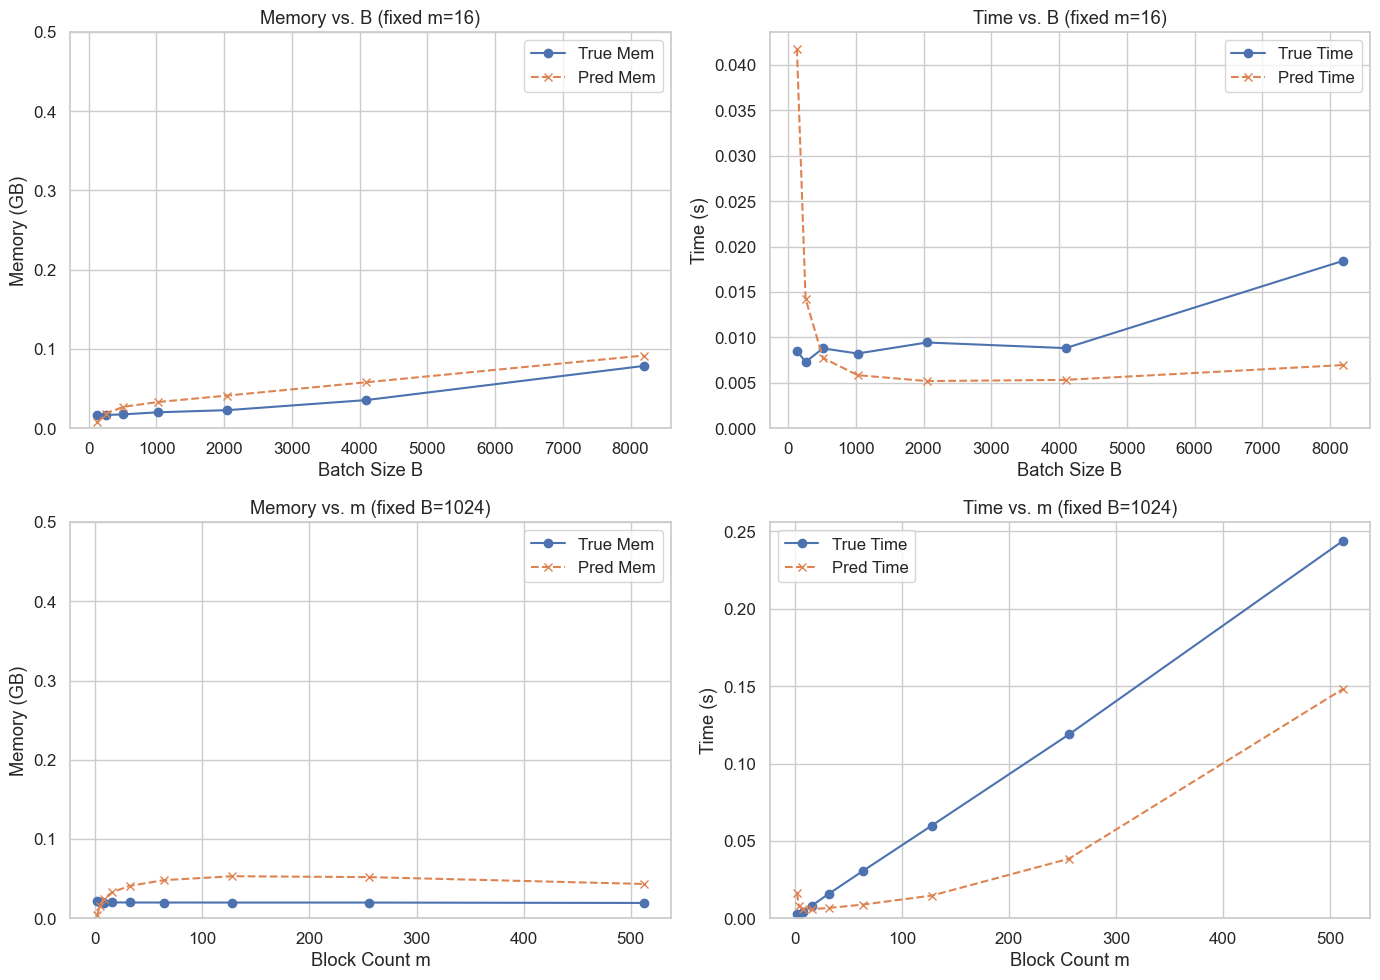

In [661]:
result_df = generate_df_plot_from_df(df_C, ft_model_C, ds_C.X_scaler, ds_C.y_scaler)
result_df.head()
plot_by_m_and_B_fixed(result_df, m0=16, B0=1024, max_mem = 0.5)


In [638]:
new_df = pd.read_csv('final_simclr_summary.csv')
new_df =  new_df.sample(frac=1).reset_index(drop=True)
base = 35533.8
new_df['memory_MB'] = new_df['memory_MB'] - base



In [639]:
new_df

,device,B,m,memory_MB,time_sec
0,device12,9758,8,12597.9,169.34
1,device12,9758,128,12597.9,1363.64
2,device12,9830,16,12597.9,162.09
3,device12,9327,256,12597.9,1895.99
4,device12,9521,1,10318.2,149.03
...,...,...,...,...,...
58,device12,5064,1,-5778.0,163.17
59,device12,8862,1,-5778.0,180.28
60,device12,9866,128,12597.9,1852.02
61,device12,8192,8,12597.9,162.57


In [640]:
def enforce_monotonic_envelopes(df, memory_col='memory_MB', time_col='time_sec', B_col='B', m_col='m'):
    df = df.copy()

    def enforce_monotonic(df, group_col, sort_col, target_col, direction='increasing'):
        """
        Enforces monotonicity on target_col, over sorted values of sort_col, within each group_col.
        direction: 'increasing' or 'decreasing'
        """
        for g_val in sorted(df[group_col].unique()):
            sub = df[df[group_col] == g_val].sort_values(sort_col)
            idxs = sub.index.tolist()

            envelope = None  # running slope
            last_val = None
            last_sort = None

            for i in idxs:
                curr_val = df.at[i, target_col]
                curr_sort = df.at[i, sort_col]

                if last_val is not None:
                    if direction == 'increasing' and curr_val < last_val:
                        if envelope is None:
                            envelope = (last_val - df.at[idxs[0], target_col]) / (last_sort - df.at[idxs[0], sort_col] + 1e-6)
                        df.at[i, target_col] = last_val + envelope * (curr_sort - last_sort)
                    elif direction == 'decreasing' and curr_val > last_val:
                        if envelope is None:
                            envelope = (df.at[idxs[0], target_col] - last_val) / (last_sort - df.at[idxs[0], sort_col] + 1e-6)
                        df.at[i, target_col] = last_val - envelope * (curr_sort - last_sort)

                last_val = df.at[i, target_col]
                last_sort = curr_sort

    # === Memory: Increase with B (fixed m), Decrease with m (fixed B) ===
    enforce_monotonic(df, group_col=m_col, sort_col=B_col, target_col=memory_col, direction='increasing')
    enforce_monotonic(df, group_col=B_col, sort_col=m_col, target_col=memory_col, direction='decreasing')

    # === Time: Increase with both B and m ===
    enforce_monotonic(df, group_col=m_col, sort_col=B_col, target_col=time_col, direction='increasing')
    enforce_monotonic(df, group_col=B_col, sort_col=m_col, target_col=time_col, direction='increasing')

    return df

In [641]:
df_fixed = new_df.copy()
df_fixed = enforce_monotonic_envelopes(df_fixed)
df_fixed = df_fixed[(df_fixed["time_sec"] > 0) & (df_fixed["memory_MB"] > 0)].copy()
df_fixed = prepare_features(df_fixed)

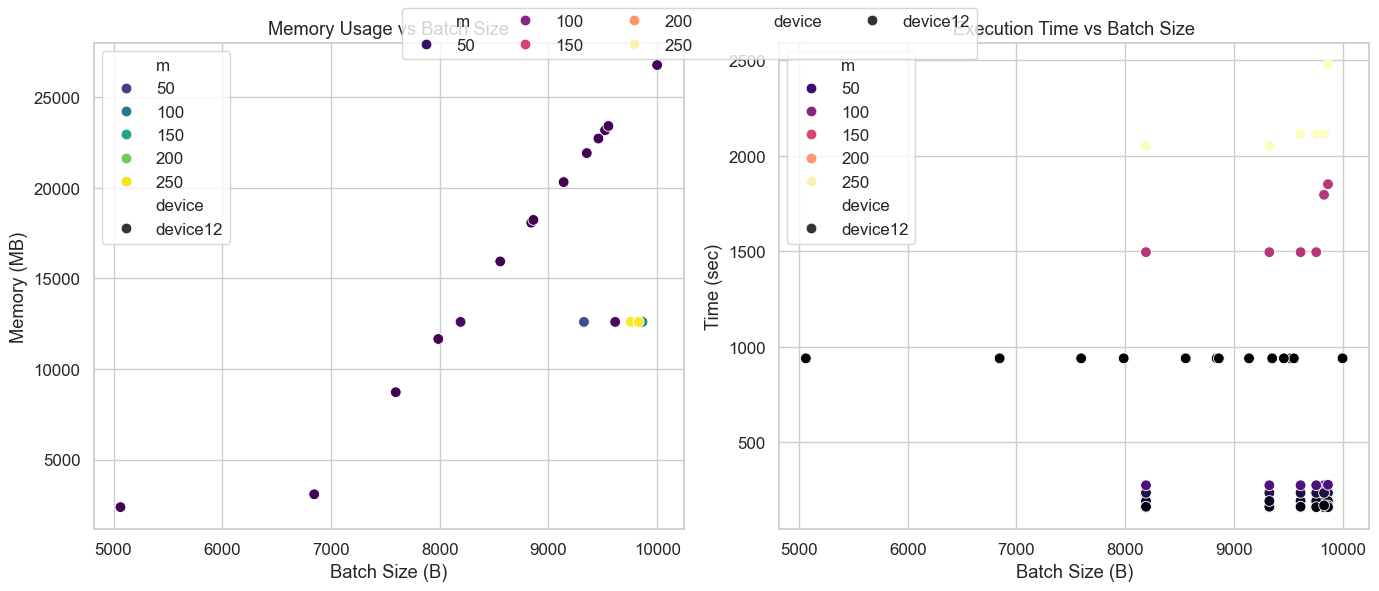

In [642]:
plot_device_profile(df_fixed)

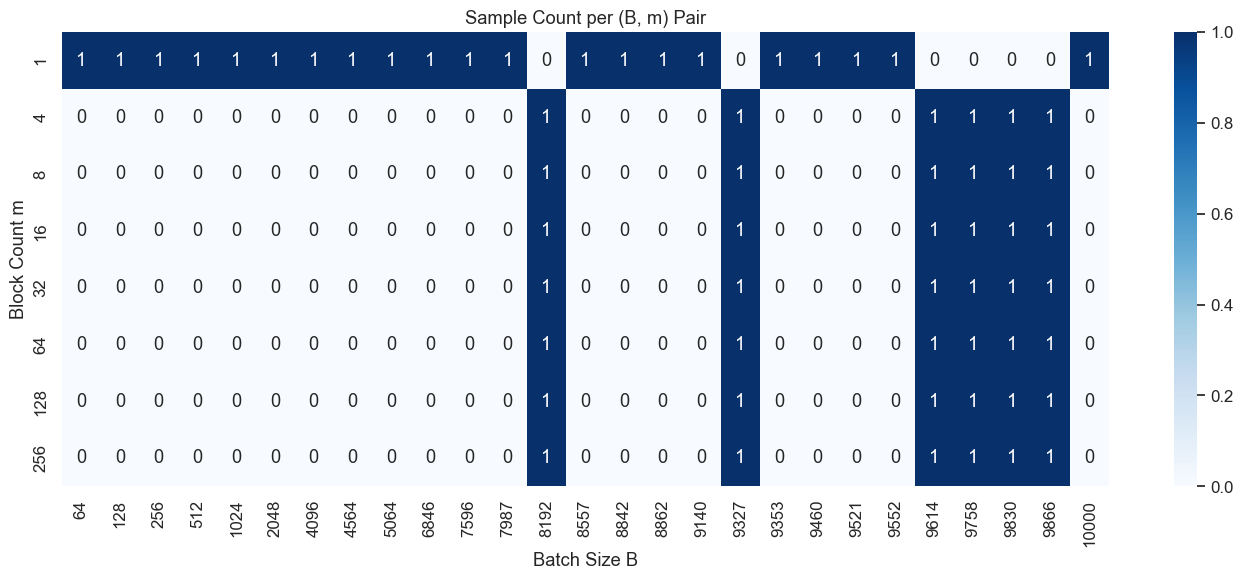

In [643]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assume `new_df` is your DataFrame
pivot = new_df.pivot_table(index='m', columns='B', values='time_sec', aggfunc='count', fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.title("Sample Count per (B, m) Pair")
plt.xlabel("Batch Size B")
plt.ylabel("Block Count m")
plt.tight_layout()
plt.show()


In [644]:
total_possible = len(new_df['B'].unique()) * len(new_df['m'].unique())
actual_samples = len(new_df)
sparsity = 1 - actual_samples / total_possible

print(f"🔢 Total (B, m) slots: {total_possible}")
print(f"📦 Filled slots: {actual_samples}")
print(f"🚨 Sparsity: {sparsity * 100:.2f}%")

🔢 Total (B, m) slots: 216
📦 Filled slots: 63
🚨 Sparsity: 70.83%


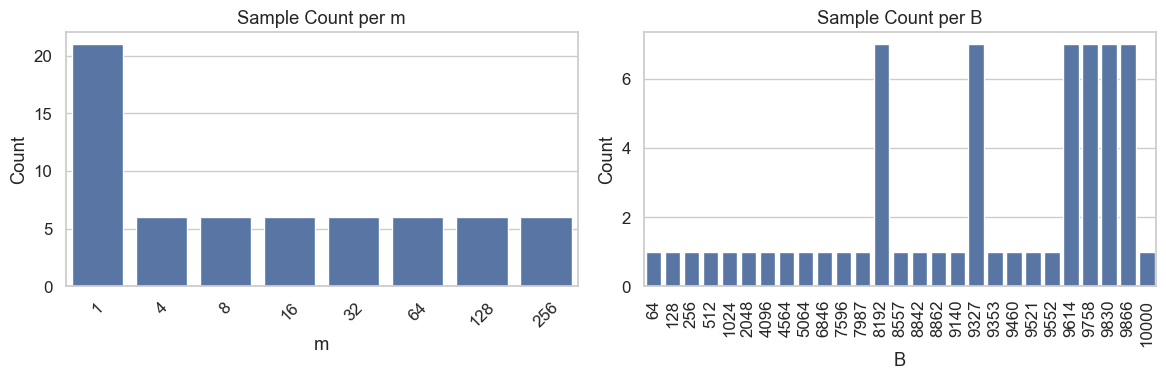

In [645]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x="m", data=new_df, ax=axes[0])
axes[0].set_title("Sample Count per m")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x="B", data=new_df, ax=axes[1])
axes[1].set_title("Sample Count per B")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [646]:
ds_n = NormalizedSplitDataset(
    df_fixed,
    features,
    representative_sampling=True,
    n_clusters=25,
    cluster_on='X'
)
X_restn, y_restn, X_fewn, y_fewn = ds_n.get_tensors()



In [647]:
ft_modeln, thetan, y_predn = few_shot_finetune_torch_with_bias(
    ft_model,
    X_fewn, y_fewn,
    X_restn, y_restn,
    epochs= 200,
    scaler=ds_n,
    verbose=True
)

Epoch 1/200 — Train Loss: 0.4322, Val Loss: 0.3631
Epoch 2/200 — Train Loss: 0.4111, Val Loss: 0.3481
Epoch 3/200 — Train Loss: 0.3559, Val Loss: 0.3345
Epoch 4/200 — Train Loss: 0.3429, Val Loss: 0.3223
Epoch 5/200 — Train Loss: 0.3107, Val Loss: 0.3115
Epoch 6/200 — Train Loss: 0.2925, Val Loss: 0.3020
Epoch 7/200 — Train Loss: 0.2606, Val Loss: 0.2937
Epoch 8/200 — Train Loss: 0.2662, Val Loss: 0.2865
Epoch 9/200 — Train Loss: 0.2345, Val Loss: 0.2805
Epoch 10/200 — Train Loss: 0.2379, Val Loss: 0.2755
Epoch 11/200 — Train Loss: 0.2255, Val Loss: 0.2714
Epoch 12/200 — Train Loss: 0.2035, Val Loss: 0.2680
Epoch 13/200 — Train Loss: 0.1983, Val Loss: 0.2655
Epoch 14/200 — Train Loss: 0.1791, Val Loss: 0.2636
Epoch 15/200 — Train Loss: 0.1882, Val Loss: 0.2624
Epoch 16/200 — Train Loss: 0.1745, Val Loss: 0.2617
Epoch 17/200 — Train Loss: 0.1377, Val Loss: 0.2614
Epoch 18/200 — Train Loss: 0.1422, Val Loss: 0.2615
Epoch 19/200 — Train Loss: 0.1117, Val Loss: 0.2618
Epoch 20/200 — Train 

📦 Mem RMSE: 5729.95 MB
⏱ Time RMSE: 401.03 sec
📦 Mem Relative Error: 51.62%
⏱ Time Relative Error: 27.99%
[0] GT → mem=12597.90, time=2053.14  |  Pred → mem=12782.87, time=1364.73
[1] GT → mem=12597.90, time=192.37  |  Pred → mem=12658.90, time=156.18
[2] GT → mem=11654.62, time=939.72  |  Pred → mem=11561.84, time=1245.26
[3] GT → mem=12597.90, time=235.20  |  Pred → mem=12956.45, time=193.08
[4] GT → mem=12597.90, time=192.37  |  Pred → mem=12293.30, time=159.29


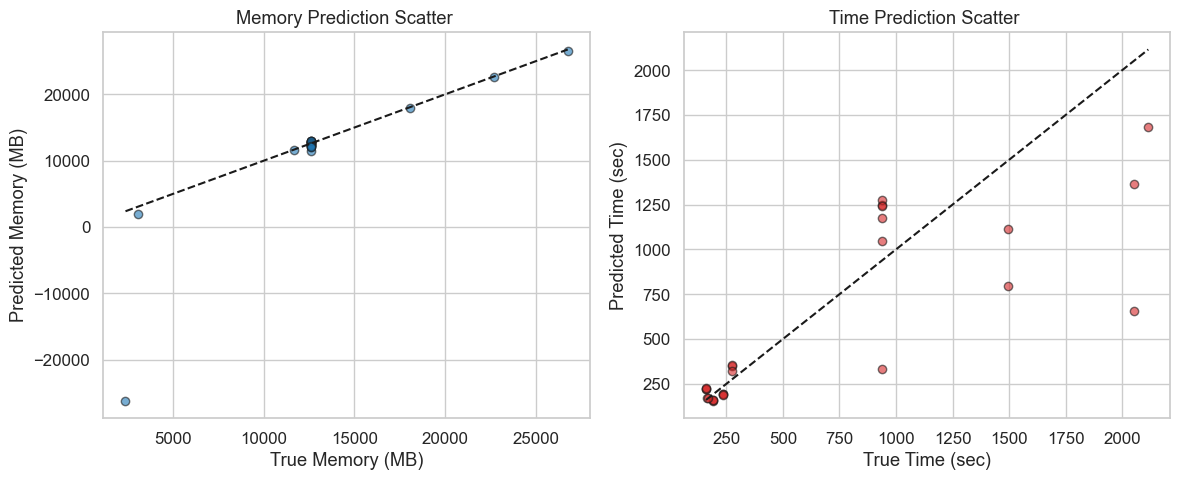

TypeError: plot_bias_corrected_predictions() got an unexpected keyword argument 'plt_name'

In [ ]:
evaluate_model([ft_modeln, thetan], X_restn, y_restn, ds_n)
plot_bias_corrected_predictions(y_restn.cpu().numpy(), y_predn, scaler=ds_n, title_suffix="")

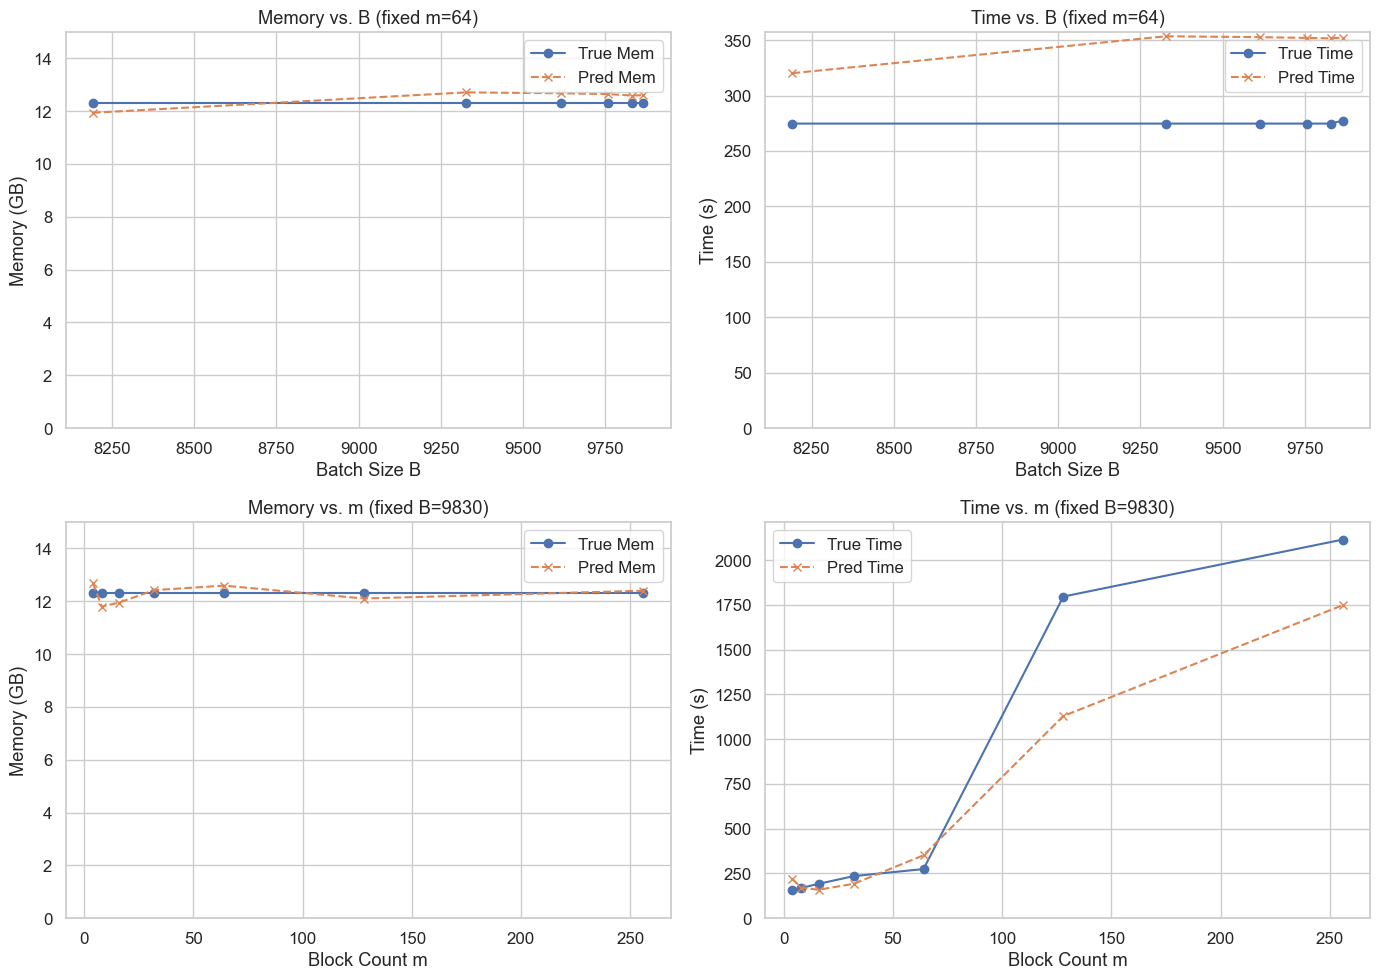

In [707]:
summary_pred_df = generate_df_plot_from_df(
    df_fixed,
    [ft_modeln, thetan],
    ds_n.X_scaler,
    ds_n.y_scaler,
    apply_exp_time=True
)
plot_by_m_and_B_fixed(summary_pred_df, m0=64, B0=9830, max_mem=15)

In [696]:
def g(B, m, model, theta, x_scaler, y_scaler, device='cpu'):
    """
    Predict memory (MB) and time (s) using a shifted model and theta correction.

    Args:
        B (int or float): Batch size
        m (int or float): Block count
        model (torch.nn.Module): Base trained model
        theta (torch.Tensor): Correction weights of shape (F+1, 2)
        x_scaler (StandardScaler): Input scaler
        y_scaler (StandardScaler): Output scaler
        device (str or torch.device): 'cpu' or 'cuda'

    Returns:
        mem_pred (float): Predicted memory in MB
        time_pred (float): Predicted time in seconds
    """
    # Construct features
    x_np = build_feature_vector(B,m)
    x_scaled = x_scaler.transform(x_np)

    # To torch tensor
    x_tensor = torch.from_numpy(x_scaled).float().to(device)

    # Add bias column for design matrix
    ones = torch.ones((1, 1), device=device)
    x_design = torch.cat([x_tensor, ones], dim=1)  # shape (1, F+1)

    # Model prediction + correction
    model.eval()
    with torch.no_grad():
        base_pred = model(x_tensor)                  # shape (1, 2)
        correction = x_design @ theta.to(device)     # shape (1, 2)
        y_scaled = (base_pred + correction).cpu().numpy()

    # Inverse transform
    mem_pred, log_time_pred = y_scaler.inverse_transform(y_scaled)[0] 
    time_pred = np.exp(np.abs(log_time_pred))

    return mem_pred/1024, time_pred

In [700]:
mem, time = g(6373, 128, model=ft_modeln, theta=thetan, x_scaler=ds_n.X_scaler, y_scaler=ds_n.y_scaler, device='cpu')
print(f"Predicted Memory = {mem:.2f} GB, Time = {time:.2f} s")

Predicted Memory = 4.19 GB, Time = 249.75 s


In [701]:
def binary_search_optimization(time_threshold, memory_threshold, batch_size_range, block_range, g, model , theta,x_scaler, y_scaler ):
 
    # Initialize the binary search ranges
    min_B, max_B = batch_size_range
    min_m, max_m = block_range

    # Variables to store the optimal batch size and block number
    optimal_B = min_B
    optimal_m = min_m

    # Binary search over batch size B
    while min_B <= max_B:
        B = (min_B + max_B) // 2  # Mid point for batch size B

        # Binary search over block size m for the current B
        current_min_m, current_max_m = min_m, max_m
        while current_min_m <= current_max_m:
            m = (current_min_m + current_max_m) // 2  # Mid point for block number m

            # Get time and memory usage for the current B and m
            memory_req,time_req  = g(B, m, model, theta, x_scaler, y_scaler, device='cpu')
            # Check if both time and memory constraints are satisfied
            if time_req <= time_threshold and memory_req <= memory_threshold and memory_req> 0 and time_req > 0:
                # If constraints are satisfied, try larger batch size
                optimal_B, optimal_m = B, m
                current_min_m = m + 1  # Increase block number to explore larger batch sizes
            else:
                # If constraints are violated, reduce the block number
                current_max_m = m - 1

        # After iterating over all m for this B, check if we need to increase or decrease B
        if optimal_B == B:
            min_B = B + 1  # Increase batch size
        else:
            max_B = B - 1  # Decrease batch size

    return optimal_B, optimal_m, time_req, memory_req


# Example usage:



# Thresholds
time_threshold = 100 # Example time threshold (in seconds)
memory_threshold = 8 # Example memory threshold (in MB)

# Range for batch size and block number
batch_size_range = (1024, 10000)  # Example batch size range (min_B, max_B)
block_range = (4, 512)  # Example block range (min_m, max_m)

# Find the optimal batch size and block number
optimal_B, optimal_m,time_req, memory_req = binary_search_optimization(time_threshold, memory_threshold, batch_size_range, block_range, g,model=ft_modeln, theta=thetan, x_scaler=ds_n.X_scaler, y_scaler=ds_n.y_scaler)
print(f"Within {time_req:.2f} sec and using {memory_req:.2f} GB memory")
print(f"Optimal batch size (B): {optimal_B}")
print(f"Optimal number of blocks (m): {optimal_m}")


Within 2.06 sec and using 8.04 GB memory
Optimal batch size (B): 6373
Optimal number of blocks (m): 405
